In [34]:
import csv
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor

FILE = 'France'
filePath = 'C:\\Users\\moria\\OneDrive\\Universität\\Bachelor\\Project\\KubernetesScheduler\\co2_prediction\\'+FILE+'_CO2_Signal_2018.csv'
co2_emission_column = 3
unix_timestamp_column = 1

df = pd.DataFrame
a = 0
time = []
emission = []
timezone_unix_factor = 3600 # factor is necessary, as the unix timestamp is not standard compliant as timezone is set to UTC + 1
with open(filePath, 'r') as csvfile:
    lines = csv.reader(csvfile, delimiter=',')
    next(lines)  # skip the label field
    for row in lines:
        a = a + 1
        day = datetime.datetime.fromtimestamp(
            int(row[unix_timestamp_column]) - timezone_unix_factor)  # correction as timestamp is UTC not UTC + 1
        time.append(day)
        try:
            emission.append(float(row[co2_emission_column]))
        except:
            emission.append(None)
df = pd.DataFrame(list(zip(time, emission)), columns=['Date', 'y'])


In [35]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates(subset=['Date'])

df = df.set_index('Date')
df = df.asfreq('H')
df = df.interpolate('ffill')

<AxesSubplot:xlabel='Date'>

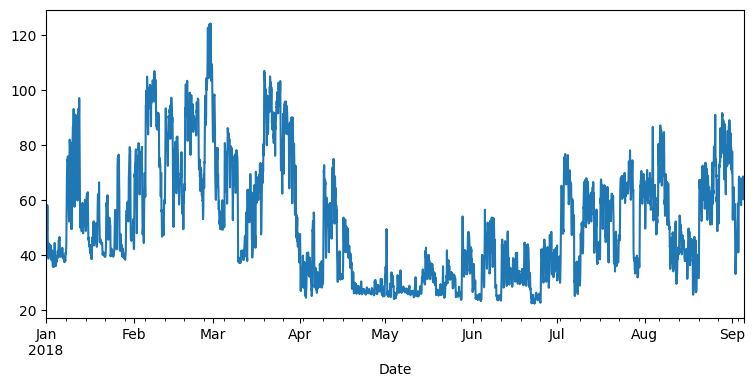

In [36]:
steps = 24
offset = 24*117 # 117
df_offset = df[:-offset]
data_train = df_offset[:-steps]
data_test_final = df_offset[-steps:]
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
#data_test['y'].plot(ax=ax, label='test')
#ax.legend()

In [43]:
#Ger 400 lags, 20 depth, 10 estim - 4% 
#Fra 400 lags, 10 depth, 16 estim - 12,1%
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=16, random_state=123),
                #regressor = RandomForestRegressor(random_state=123),
                lags      = 400
             )
forecaster.fit(y=data_train['y'])

In [44]:
predictions = forecaster.predict(steps=steps)
print(predictions.head(5))

2018-09-05 00:00:00    60.101516
2018-09-05 01:00:00    60.555844
2018-09-05 02:00:00    60.526465
2018-09-05 03:00:00    60.995202
2018-09-05 04:00:00    60.796173
Freq: H, Name: pred, dtype: float64


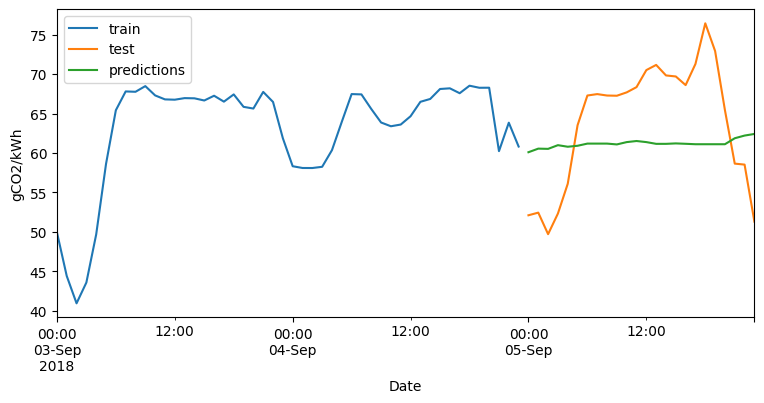

In [45]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train[-steps*2:]['y'].plot(ax=ax, label='train', xlabel='time', ylabel='gCO2/kWh')
data_test_final['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.savefig(FILE+"_autoreg_prediction.pdf", bbox_inches="tight")

In [46]:
error = mape(data_test_final['y'], predictions)
print(error)

0.12100129053925317


In [47]:
print("observed min")
data_test_final[['y']].idxmin()

observed min


y   2018-09-05 02:00:00
dtype: datetime64[ns]

In [48]:
print("min of prediction")
predictions.idxmin()

min of prediction


Timestamp('2018-09-05 00:00:00', freq='H')